<h1><center>TEXT CLASSIFCATION USING BERT AND LSTM</center></h1>

**Note:**  

The Notebook has to run with GPU to prevent out of memory issue.

In this project, we will classify a group of BBC articles into 5 predefined categories. We will use the BERT embedding with a simple dense classifier and LSTM. 

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00


The transformers library is a popular library for Natural Language Processing (NLP) tasks that includes pre-trained models like BERT, GPT-2, etc. and provides an easy-to-use interface for fine-tuning these models on specific NLP tasks. 

sentencepiece is a tokenizer used in BERT and other transformer-based models. It is used to split text into subword tokens that can be better understood by the model. These subword tokens are then used as input to the model instead of the original words. Installing these packages will allow us to use transformer-based models for our classification task.

In [ ]:
#Import statements
import pandas as pd
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import BertTokenizer,BertModel
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
import re
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

The libraries and modules you are importing are:

**pandas**: a library for data manipulation and analysis.


**torch**: a library for machine learning and deep learning.


**seaborn**: a library for data visualization.


**train_test_split**: a function from scikit-learn for splitting data into training and testing sets.


**tqdm**: a library for showing progress bars during long-running tasks.


**BertTokenizer and BertModel**: classes from the transformers library for using the pre-trained BERT model for natural language processing tasks.


**nn**: a module from PyTorch containing various neural network layers and functions.


**DataLoader and TensorDataset**: classes from PyTorch for creating datasets and data loaders for machine learning tasks.


**optim**: a module from PyTorch containing various optimization algorithms for training neural networks.


**ConfusionMatrixDisplay and classification_report**: functions from scikit-learn for evaluating classification models.


**re**: a module for working with regular expressions.


**nltk**: the Natural Language Toolkit, a library for natural language processing tasks.


**WordCloud**: a library for creating word clouds.


**WordNetLemmatizer**: a class from NLTK for lemmatizing words.


**matplotlib.pyplot**: a module for creating data visualizations.


**TfidfVectorizer**: a class from scikit-learn for creating TF-IDF feature vectors from text data.


**RandomForestClassifier**: a class from scikit-learn for training a random forest classifier.


**nltk.download**: a function from NLTK for downloading datasets and resources used by the library

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

This line of code is checking if a CUDA-enabled GPU is available on the system or not. If a CUDA-enabled GPU is available, the code will set the device variable to 'cuda', otherwise it will set it to 'cpu'.

device variable is later used to move tensors to the GPU device or the CPU device, depending on the availability of the CUDA-enabled GPU.

This is a common practice when working with PyTorch and deep learning models since using a GPU can significantly speed up the training process for large models and datasets.

In [ ]:
#Read
url = "https://drive.google.com/file/d/1SENFhJIMG6ebhNzznlroBAs-3KcDN0VW/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data=pd.read_csv(path)

We are reading a CSV file from Google Drive using its URL.
The url variable contains the URL of the file, and the path variable is created by extracting the file ID from the URL and appending it to the Google Drive download link.

Finally, the pd.read_csv() function is used to read the CSV file from the specified path into a Pandas DataFrame called data

In [ ]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
data["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

This code is calling the value_counts() method on the "category" column of the data DataFrame to count the number of occurrences of each unique value in the column. For sports, the number of occurences of each unique value in the column is 511

<h2> Distribution of the data </h2>

<Axes: xlabel='category', ylabel='Count'>

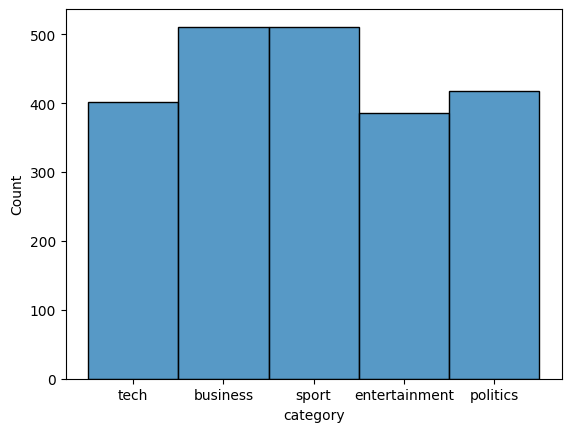

In [ ]:
sns.histplot(data["category"])

This shows histogram of distribution of data and the Y-label denotes the count 

<h2> Example of text </h2>

In [ ]:
data["text"][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

We are trying to access the first element of the "text" column in the dataframe "data".

<h2> Word frequency analysis </h2>

Word frequency analysis is a technique used to identify the most commonly occurring words in a text or corpus. It is a basic text mining technique that involves counting the frequency of each word in a given text or set of texts.

The process involves tokenizing the text into individual words or phrases and then counting the number of occurrences of each word in the text. The resulting word frequency list can be used to identify the most frequently occurring words or to perform further analysis, such as sentiment analysis or topic modeling.

Word frequency analysis can be performed using a variety of tools and libraries, such as Python's Natural Language Toolkit (NLTK), spaCy, or scikit-learn. Commonly used techniques include counting word occurrences, removing stop words, stemming or lemmatizing words, and analyzing n-grams (i.e., sequences of words)

In [ ]:
freq_data=data.copy() 

This code is creating a copy of the original data DataFrame and assigning it to a new variable called freq_data.

By creating a copy of the original DataFrame, you can modify the new DataFrame without affecting the original data.

In [ ]:
stopwords=nltk.corpus.stopwords.words('english')
stopwords=[x.lower() for x in stopwords]
stopwords=set(stopwords)

In this code, nltk.corpus.stopwords.words('english') is accessing the English stopword list from the NLTK library, and then each word is converted to lowercase using a list comprehension. Finally, the list of lowercase stopwords is converted to a set, which can make it faster to search for and remove stopwords from the text data.

In [ ]:
#Pre process the text
def pre_process_text(text):
    text_lower=text.lower() #Convert to lower case
    text_token=re.findall('[a-z]+', text_lower) #Tokenize using re to extract all alphabet charecters
    filtered_text=[]
    for token in text_token:
      if token not in stopwords:
        filtered_text.append(token)   
    return filtered_text

This code defines a function called pre_process_text() that takes in a piece of text as an input and performs several text preprocessing steps on it.

The function first converts the input text to lowercase using the lower() method. This helps to standardize the text data and can improve the effectiveness of subsequent preprocessing steps.

Next, the function uses a regular expression (re) to extract all the alphabetic characters from the text, essentially tokenizing the text into individual words or word-like sequences.

The resulting tokens are then filtered to remove any stopwords using a for loop that checks each token against the set of stopwords created earlier. Any token that is not a stopword is added to a new list called filtered_text.

Finally, the function returns the list of filtered tokens, which can be used for further text analysis or modeling.

Overall, this function performs basic text preprocessing steps such as lowercasing, tokenization, and stopword removal, which are commonly used in natural language processing and text analysis tasks.

In [ ]:
freq_data["preprocessed_text"]=freq_data['text'].apply(pre_process_text)

This line of code is applying the pre_process_text() function to the text column of the freq_data DataFrame and storing the resulting preprocessed text as a new column called preprocessed_text.

This allows we to add preprocessed text data to the DataFrame that can be used for text analysis and modeling.

By using the apply() method in conjunction with the pre_process_text() function, we can efficiently apply the same preprocessing steps to every row of text data in the DataFrame.

In [ ]:
freq_data.head()

,category,text,preprocessed_text
0,tech,tv future in the hands of viewers with home th...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,"[ocean, twelve, raids, box, office, ocean, twe..."


This code is displaying the first few rows of the freq_data DataFrame to inspect the new preprocessed_text column that was added by the previous line of code.

By default, head() shows the first 5 rows of the DataFrame. This allows us to quickly see whether the new column was added correctly and how the preprocessed text data looks.

In [ ]:
#Function to get word cloud based on frequency

# Define function to generate word cloud for a given category
def get_word_cloud(category):
  all_word_list=[]
  df=freq_data[freq_data['category']==category] # Get the subset of the data corresponding to the given category
  for text_list in df["preprocessed_text"]:
    all_word_list=all_word_list+text_list #Combine all preprocessed text from the subset into a single list

  # Define and generate the word cloud
  wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(" ".join(all_word_list))

  # Plot and display the word cloud
  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')
  plt.imshow(wordcloud)
  plt.show()
  


This code defines a function called get_word_cloud() that generates a word cloud visualization for a given category of text data.

The function takes a single input, category, which specifies the category of text data for which the word cloud should be generated. The function first selects all rows of the freq_data DataFrame that match the specified category using boolean indexing.

Then, the function extracts the preprocessed text data from the selected rows and concatenates all the words into a single list called all_word_list. This list of words is then passed to the WordCloud() function from the wordcloud package, which generates the actual word cloud image.

The resulting image is displayed using matplotlib.pyplot methods. The plt.imshow() method displays the image itself, while plt.axis('off') removes the x and y axis labels and ticks from the plot.

Overall, this function allows you to quickly generate a visual representation of the most frequently occurring words in a given category of text data, which can be useful for identifying common themes or topics in the data.

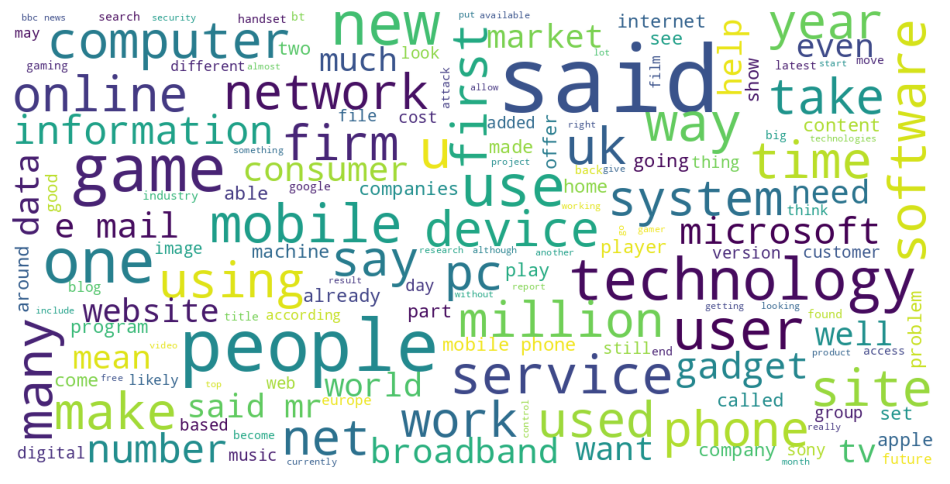

In [ ]:
get_word_cloud("tech")

This code is calling the get_word_cloud() function with the argument "tech", which generates a word cloud visualization for the category of text data labeled as "tech" in the freq_data DataFrame.

The resulting word cloud image shows the most frequently occurring words in the preprocessed text data for the "tech" category, with larger words indicating greater frequency of occurrence.

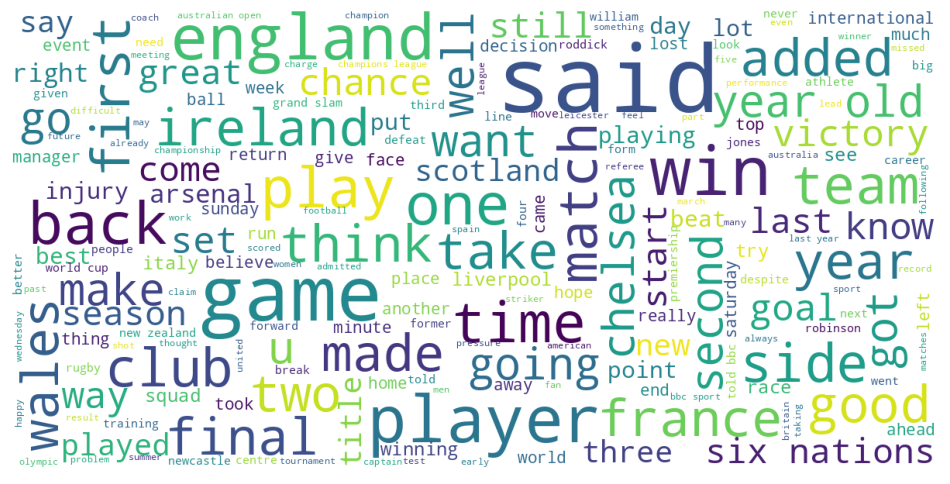

In [ ]:
get_word_cloud("sport")

This code is calling the get_word_cloud() function with the argument "sport", which generates a word cloud visualization for the category of text data labeled as "sport" in the freq_data DataFrame.

The resulting word cloud image shows the most frequently occurring words in the preprocessed text data for the "sport" category, with larger words indicating greater frequency of occurrence. This can be useful for gaining an initial understanding of the kinds of topics or themes that are common in this category of text data.

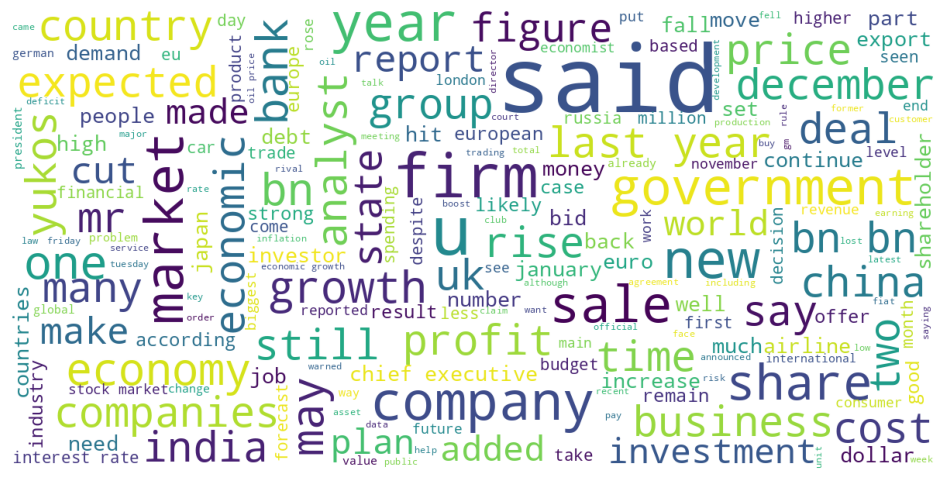

In [ ]:
get_word_cloud("business")

This code is calling the get_word_cloud() function with the argument "business", which generates a word cloud visualization for the category of text data labeled as "business" in the freq_data DataFrame.

The resulting word cloud image shows the most frequently occurring words in the preprocessed text data for the "business" category, with larger words indicating greater frequency of occurrence. This can be useful for gaining an initial understanding of the kinds of topics or themes that are common in this category of text data.

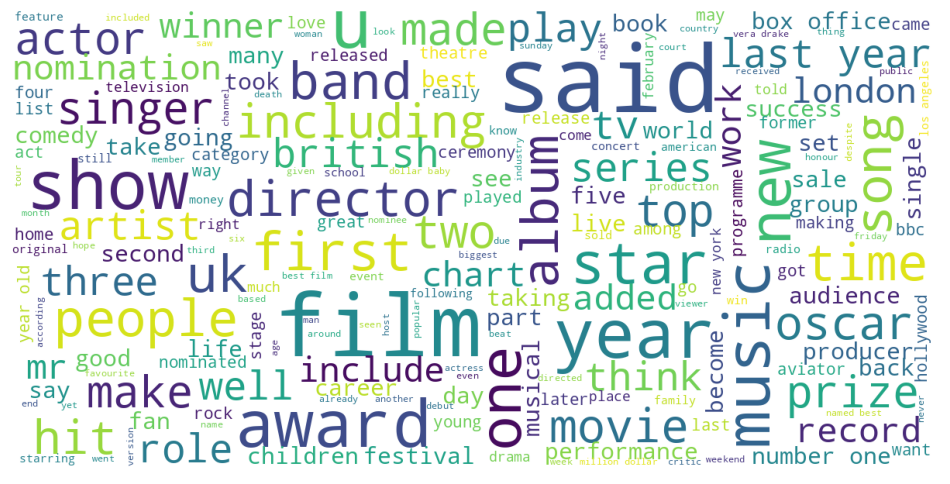

In [ ]:
get_word_cloud("entertainment")

This code is calling the get_word_cloud() function with the argument "entertainment", which generates a word cloud visualization for the category of text data labeled as "entertainment" in the freq_data DataFrame.

The resulting word cloud image shows the most frequently occurring words in the preprocessed text data for the "entertainment" category, with larger words indicating greater frequency of occurrence. This can be useful for gaining an initial understanding of the kinds of topics or themes that are common in this category of text data.

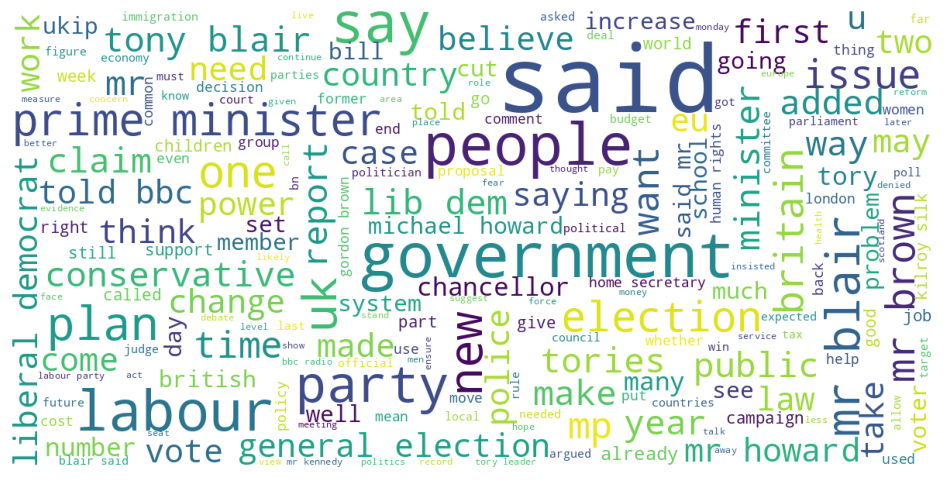

In [ ]:
get_word_cloud("politics")

This code is calling the get_word_cloud() function with the argument "politics", which generates a word cloud visualization for the category of text data labeled as "politics" in the freq_data DataFrame.

The resulting word cloud image shows the most frequently occurring words in the preprocessed text data for the "politics" category, with larger words indicating greater frequency of occurrence. This can be useful for gaining an initial understanding of the kinds of topics or themes that are common in this category of text data.

<h2> Format the data </h2>

<h3> Encode the labels </h3>

In [ ]:
#Encode the labels
encode_dict= {
            "sport":0,
            "business":1,
            "politics":2,
            "tech":3,
            "entertainment":4
           }

This code defines a Python dictionary called encode_dict that maps each of the five categories in the dataset ("sport", "business", "politics", "tech", and "entertainment") to a numeric label. The labels assigned in this dictionary are simply integers ranging from 0 to 4.

In [ ]:
X_data=data["text"]
Y_data=data["category"].map(encode_dict)

This code extracts the text data and corresponding category labels from the data DataFrame and assigns them to X_data and Y_data, respectively.

X_data is a pandas Series object containing the raw text data for each news article, while Y_data is a pandas Series object containing the numeric label for each article's category, obtained by mapping the original string labels to their corresponding integer values using the encode_dict dictionary defined earlier

In [ ]:
X_data.head()

0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object

This contains the raw text data for each article's category. The data type here is object

In [ ]:
Y_data.head()

0    3
1    1
2    0
3    0
4    4
Name: category, dtype: int64

This contains numeric label for each article's category. The data type here is object

<h3> Split data into train and test </h3>

In [ ]:
X_train, X_test,Y_train, Y_test = \
train_test_split(X_data,Y_data,test_size=0.2)

The first two arguments, X_data and Y_data, represent the input features and output labels of the dataset, respectively.

The test_size argument specifies the proportion of the dataset that should be used for testing. In this case, test_size=0.2 means that 20% of the dataset will be used for testing, and the remaining 80% will be used for training.

The function returns four arrays:

X_train: the input features for the training set.
X_test: the input features for the testing set.
Y_train: the output labels for the training set.
Y_test: the output labels for the testing set.

<h3> Further split train data into train and validation data </h3>

In [ ]:
X_train, X_val,Y_train, Y_val = \
train_test_split(X_train,Y_train,test_size=0.2)

This new split is useful for tuning hyperparameters and selecting the best model architecture as it helps to prevent overfitting on the original training data. The model can be trained on the new training set and evaluated on the validation set to see how well it generalizes to new data.

<h3> Data counts in each set </h3>

In [ ]:
print("TRAINING DATA",len(X_train))
print("VALIDATION DATA",len(X_val))
print("TEST DATA",len(X_test))

TRAINING DATA 1424
VALIDATION DATA 356
TEST DATA 445


This is printing the number of samples in the training, validation, and testing sets. The len() function is used to determine the length of each array. In this case, X_train, X_val, and X_test represent the input features of their respective sets.

By printing the number of samples in each set, we can get an idea of the size of the dataset and how it is split between the training, validation, and testing sets

<h2> Baseline TF-IDF model </h2>

TF-IDF (Term Frequency-Inverse Document Frequency) is a widely used technique for text data preprocessing and feature extraction. It aims to capture the importance of a word in a document or corpus by calculating a score that takes into account the frequency of the word in the document and its frequency across all documents.

Here are the general steps to build a TF-IDF model:

**Data Preprocessing**: The text data needs to be preprocessed before building the model. 

**Tokenization**: The text is split into individual words or tokens, which are the basic units for building the TF-IDF model.

**Term Frequency (TF)**: For each token in a document, calculate the number of times it appears in the document

**Inverse Document Frequency (IDF)**: Calculate the inverse document frequency (IDF) of each token, which measures how important the token is across all documents.

**TF-IDF Vectorization**: Multiply the term frequency (TF) of each token in the document by its inverse document frequency (IDF) to get the TF-IDF score.

**Model Training**: Once the TF-IDF vectors are computed for each document in the corpus, a machine learning model can be trained using the TF-IDF scores as input features.

**Model Evaluation** : The performance of the TF-IDF model can be evaluated using standard machine learning evaluation metrics, such as accuracy, precision, recall, and F1-score.

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', stop_words="english", token_pattern=r"\w+",lowercase=True)  
tfidf_vect.fit(X_train)

TfidfVectorizer(stop_words='english', token_pattern='\\w+')

This initializes a TfidfVectorizer object with the following parameters:

**analyzer='word'**: The analyzer used to split the text into words.

**stop_words="english"**: A list of stop words to be removed from the text. In this case, the built-in list of English stop words is used.

**token_pattern=r"\w+"**: A regular expression pattern used to tokenize the text. In this case, the pattern matches any alphanumeric character (\w+) and ensures that at least one character is present.

**lowercase=True**: A boolean value indicating whether to convert all text to lowercase before tokenizing.

**The tfidf_vect.fit(X_train)** 
This fits the TfidfVectorizer object to the training data, X_train. This step calculates the IDF values for each token in the corpus and stores them in the vectorizer object for later use.

In [ ]:
X_train_tfidf_vec=tfidf_vect.transform(X_train)
X_val_tfidf_vec=tfidf_vect.transform(X_val)
X_test_tfidf_vec=tfidf_vect.transform(X_test)

This provides transforms the training, validation, and testing data into their respective TF-IDF vector representations using the previously fitted TfidfVectorizer object. 

**X_train_tfidf_vec = tfidf_vect.transform(X_train):**

This transforms the training data, X_train, into a matrix of TF-IDF vectors using the previously fitted TfidfVectorizer object, tfidf_vect. The resulting matrix has one row for each document in X_train and one column for each unique token in the entire corpus. The values in the matrix represent the TF-IDF score for each token in each document.

**X_val_tfidf_vec = tfidf_vect.transform(X_val)**:

This transforms the validation data, X_val, into a matrix of TF-IDF vectors using the same TfidfVectorizer object, tfidf_vect. The resulting matrix has the same dimensions as the one obtained for the training data.

**X_test_tfidf_vec = tfidf_vect.transform(X_test)**:

This transforms the testing data, X_test, into a matrix of TF-IDF vectors using the same TfidfVectorizer object, tfidf_vect. The resulting matrix has the same dimensions as the one obtained for the training and validation data.

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_tfidf_vec, Y_train)

RandomForestClassifier()

This provides trains a RandomForestClassifier model on the training data represented as TF-IDF vectors

**clf = RandomForestClassifier()**:

This initializes a RandomForestClassifier object with default hyperparameters.

**clf.fit(X_train_tfidf_vec, Y_train)**:

This trains the RandomForestClassifier object, clf, on the training data represented as TF-IDF vectors, X_train_tfidf_vec, and their corresponding target labels, Y_train. This step fits the model to the training data by adjusting its parameters to minimize the classification error.

In [ ]:
tfidf_pred=clf.predict(X_test_tfidf_vec)


This provides the trained RandomForestClassifier model to predict the target labels of the testing data represented as TF-IDF vectors.

**tfidf_pred = clf.predict(X_test_tfidf_vec):**

This predicts the target labels of the testing data represented as TF-IDF vectors, X_test_tfidf_vec, using the trained RandomForestClassifier model, clf. This step applies the learned model to the input data to make predictions

In [ ]:
print(classification_report(Y_test,tfidf_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       102
           1       0.92      0.96      0.94        95
           2       0.92      0.97      0.94        88
           3       1.00      0.92      0.96        79
           4       0.99      0.91      0.95        81

    accuracy                           0.95       445
   macro avg       0.96      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



It is the classification report for TF-IDF model. It shows precision, recall and f1-score for each class.

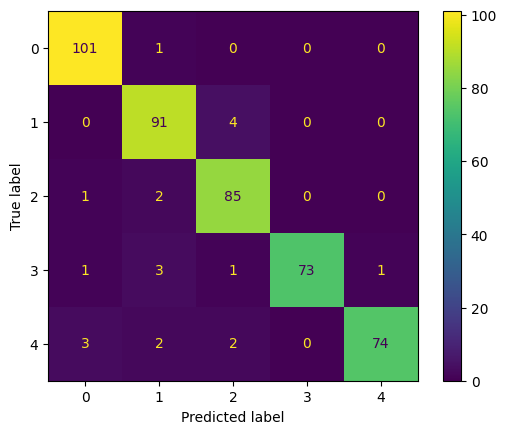

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,tfidf_pred)

This is a confusion matrix

<h2> GET BERT EMBEDDINGS OF THE DATA </h2>
<h3> Use the hugging face transformer package to the BERT pretrained embeddings </h3>

BERT embedding is the process of representing words or sentences in a vector form using pre-trained BERT models. BERT stands for Bidirectional Encoder Representations from Transformers, which is a transformer-based neural network architecture used for natural language processing (NLP) tasks such as text classification, question-answering, and named entity recognition. BERT uses a pre-trained language model that learns contextual relations between words in a sentence and encodes them into a dense vector representation, which is then used as an input to a downstream NLP task. The pre-trained BERT models are trained on large amounts of text data using a self-supervised learning method, which allows them to learn high-quality representations that can be used in various NLP tasks with fine-tuning.

In [ ]:
MAX_SEQ_LEN_BERT=256 #max length for bert

MAX_SEQ_LEN_BERT is a variable that holds the maximum sequence length for the BERT model which in this case is 256

In [ ]:
def get_bert_embedding(text_list):
  # Load the BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',model_max_length=MAX_SEQ_LEN_BERT)

    # Load the pre-trained BERT model
    bert_model = BertModel.from_pretrained('bert-base-uncased',
                                      output_hidden_states = True,
                                      )
    
    # Set the model to evaluation mode and move it to the device (GPU)
    bert_model.eval()
    bert_model.to(device)

    vec_list=[]
    for text in tqdm(text_list):
        with torch.no_grad():
            # Encode the text using the BERT tokenizer
            encoded_text = bert_tokenizer(text, return_tensors="pt",return_attention_mask=True,\
                                       return_token_type_ids=True,padding='max_length',truncation_strategy="longest_first")
            encoded_text.to(device)

            # Pass the encoded text through the BERT model to get the embeddings
            bert_embeding = bert_model(**encoded_text)

            # Append the embeddings to the vector list
            vec_list.append(bert_embeding["last_hidden_state"])

    # Concatenate the embeddings into a single tensor along the 0-th dimension (batch dimension)
    # and return the tensor
    del bert_model
    return torch.concat(vec_list, dim=0)

The get_bert_embedding function takes a list of texts as input and returns their corresponding BERT embeddings using the Hugging Face transformers package. 

First, the function initializes a BERT tokenizer and model, both from the bert-base-uncased pre-trained model. The output_hidden_states flag is set to True to also return the hidden states of the model in addition to the final layer output.

For each text in the input list, the function first encodes it using the BERT tokenizer. The resulting encoded text includes the input text converted into token IDs, attention masks indicating which tokens to attend to and which to ignore, and token type IDs to indicate which tokens belong to the first sentence and which to the second (in case of input pairs).

The encoded text is then passed to the BERT model to obtain its embeddings. Since we set output_hidden_states=True, the BERT model returns the embeddings of all hidden layers as well as the final layer output. In this function, we extract only the embeddings of the final layer (i.e., last_hidden_state), which are returned as a tensor.

Finally, all the resulting embeddings are concatenated along the first dimension (i.e., the samples axis) and returned as a single tensor.

In [ ]:
#Get vectors of train data
X_train_vec=get_bert_embedding(X_train)
X_train_vec.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/1424 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2389: FutureWarning: The `truncatio

torch.Size([1424, 256, 768])

We are getting embeddings for train data

In [ ]:
#Get vectors of test data
X_test_vec=get_bert_embedding(X_test)
X_test_vec.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 445/445 [00:09<00:00, 45.40it/s]


torch.Size([445, 256, 768])

We are getting embeddings for test data

In [ ]:
#Get vectors of validation data
X_val_vec=get_bert_embedding(X_val)
X_val_vec.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 356/356 [00:08<00:00, 43.24it/s]


torch.Size([356, 256, 768])

We are getting embeddings for validation data

<h2>  SIMPLE DENSE CLASSIFICATON USING BERT VECTOR </h2>

In [ ]:
X_train_vec_condensed=X_train_vec.reshape(X_train_vec.shape[0],X_train_vec.shape[1]*X_train_vec.shape[2])
X_val_vec_condensed=X_val_vec.reshape(X_val_vec.shape[0],X_val_vec.shape[1]*X_val_vec.shape[2])
X_test_vec_condensed=X_test_vec.reshape(X_test_vec.shape[0],X_test_vec.shape[1]*X_test_vec.shape[2])


The above code reshapes the BERT embeddings of the train, validation, and test data into 2D arrays. 

Each instance of the train, validation, and test data initially had BERT embeddings that were 3D arrays of shape (num_tokens, hidden_size, num_layers). 

The reshape function is used to change the shape of each instance's embeddings to (num_tokens*hidden_size*num_layers,), which makes each instance a 1D array. This allows the data to be used as input for machine learning models that require a 2D array as input.

In [ ]:
X_train_vec_condensed.shape

torch.Size([1424, 196608])

X_train_vec_condensed.shape returns the shape of the 2D array X_train_vec_condensed

In [ ]:
class DenseClassifier(nn.Module):
    def __init__(self):
        super(DenseClassifier, self).__init__()

        # Define fully connected layers
        self.fc1 = nn.Linear(X_train_vec_condensed.shape[1],2048,bias=True) #Fully connected layer 1
        self.d1 = nn.Dropout(p=0.3) # Define dropout layer to prevent overfitting
        self.fc2 = nn.Linear(2048,512,bias=True)
        self.d2 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(512,64,bias=True)
        self.d3 = nn.Dropout(p=0.5)
        self.fc4=nn.Linear(64,5,bias=True)
        
    def forward(self,inp):
        
        # Define forward pass for the model
        output= self.fc1(inp) # Pass input through first layer
        output=nn.functional.relu(output) # Apply ReLU activation function
        output=self.d1(output) # Apply dropout to prevent overfitting
        
        output=self.fc2(output) # Pass through second layer
        output=nn.functional.relu(output)
        output=self.d2(output)
        
        output=self.fc3(output) #Pass through third layer
        output=nn.functional.relu(output)
        output=self.d3(output)

        output=self.fc4(output) # Pass through fourth layer
        output=nn.functional.softmax(output) # Apply softmax activation function for classification
        return output

This code defines a PyTorch neural network module called DenseClassifier. It inherits from the nn.Module base class. The module contains several fully connected layers (implemented using the nn.Linear class) and dropout layers (implemented using the nn.Dropout class). 

The constructor __init__ defines the architecture of the neural network. The input layer has the same number of neurons as the number of columns in the input data X_train_vec_condensed. The output layer has 5 neurons since there are 5 classes in the target variable. There are 3 hidden layers in the network, with 2048, 512, and 64 neurons, respectively.

The forward method specifies the forward pass of the neural network. The input inp is passed through each fully connected layer in turn, with a ReLU activation function applied to the output of each layer (except for the output layer, which uses a softmax activation function). Dropout is applied after each hidden layer. The output of the final layer is returned as the output of the network.

In [ ]:
dense_classifier = DenseClassifier()
dense_classifier

DenseClassifier(
  (fc1): Linear(in_features=196608, out_features=2048, bias=True)
  (d1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (d2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (d3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

This code defines an instance of the `DenseClassifier` class, which is a neural network model for classification. The model has four fully connected layers, with the first layer having 2048 neurons, the second layer having 512 neurons, the third layer having 64 neurons, and the output layer having 5 neurons (one for each class). Each hidden layer is followed by a dropout layer, which randomly drops out a certain percentage of the neurons to prevent overfitting. 

The `forward()` method specifies the feedforward computation of the model, which takes an input tensor `inp` and passes it through the four fully connected layers with ReLU activation functions, followed by a softmax activation function in the output layer to obtain class probabilities. The `softmax()` function ensures that the output values sum up to 1 and represent class probabilities.

In [ ]:
BATCH_SIZE_DENSE=16
dl_dense = DataLoader(TensorDataset(X_train_vec_condensed,torch.tensor(Y_train.values)), batch_size=BATCH_SIZE_DENSE)
LEN_DL_dense = len(dl_dense) #number of batches
EPOCHS_dense=10

This code sets the batch size for the data, creates a PyTorch DataLoader object from the training data and its corresponding labels, and sets the number of epochs for the training process. Specifically, BATCH_SIZE_DENSE sets the number of samples that will be passed through the network at once, TensorDataset combines the training data and its corresponding labels into a PyTorch TensorDataset object, and DataLoader combines the TensorDataset with the batch size to create an iterable data loader for the network training process. LEN_DL_dense calculates the number of batches in the data loader, and EPOCHS_dense sets the number of training epochs.

In [ ]:
dense_classifier = dense_classifier.to(device)
dense_optimizer = optim.Adam(dense_classifier.parameters(),lr=1e-4)
dense_criterion = nn.CrossEntropyLoss()
dense_criterion = dense_criterion.to(device)

This code is preparing for training the DenseClassifier model using the Adam optimizer with a learning rate of 0.0001, and the cross-entropy loss function. The model is also being moved to the device (CPU or GPU) defined earlier.

In [ ]:
# Train the dense classifier
for epoch in range(0,EPOCHS_dense):
    epoch_loss=0
    epoch_accuracy=0
    print("EPOCH",epoch+1)
    for batch, (x,y) in enumerate(dl_dense):

        # move the data to GPU if available
        x=x.to(device)
        out=dense_classifier(x)
        y=y.to(device)
        dense_optimizer.zero_grad()

        # compute loss
        loss_dense = dense_criterion(out, y)

         # compute accuracy
        acc=sum(out.detach().cpu().numpy().argmax(axis=1)==y.cpu().numpy())/BATCH_SIZE_DENSE

        # release memory
        del x
        del y
        torch.cuda.empty_cache()
        
        # backpropagation
        loss_dense.backward()      
        dense_optimizer.step()

        # accumulate the loss and accuracy for the current epoch
        epoch_loss=epoch_loss+loss_dense
        epoch_accuracy=epoch_accuracy+acc
        #endsep = "\n" if batch == LEN_DL -1 else "\r"

        # display batch-level statistics
        endsep="\r"
        print (f"Batch :: {batch+1}/{LEN_DL_dense} : Accuracy :: {acc} : loss :: {loss_dense.detach().item()}", end=endsep, flush=True)

    # display epoch-level statistics
    print("Accuracy: ",epoch_accuracy/LEN_DL_dense," loss: ",epoch_loss.item()/LEN_DL_dense)

    # evaluate the validation accuracy
    with torch.no_grad():   
        val_out=dense_classifier(X_val_vec_condensed)
        val_acc=sum(val_out.detach().cpu().numpy().argmax(axis=1)==Y_val.values)/len(Y_val)
        print("Validation Accuracy",val_acc)
        

EPOCH 1


<ipython-input-40-16337346457a>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=nn.functional.softmax(output) # Apply softmax activation function for classification


Accuracy:  0.449438202247191  loss:  1.4394320370106215
Validation Accuracy 0.6825842696629213
EPOCH 2
Accuracy:  0.8405898876404494  loss:  1.0785717910595154
Validation Accuracy 0.8735955056179775
EPOCH 3
Accuracy:  0.9578651685393258  loss:  0.9643175789479459
Validation Accuracy 0.8651685393258427
EPOCH 4
Accuracy:  0.9754213483146067  loss:  0.9369818012366135
Validation Accuracy 0.9410112359550562
EPOCH 5
Accuracy:  0.9873595505617978  loss:  0.922106024924289
Validation Accuracy 0.9719101123595506
EPOCH 6
Accuracy:  0.9936797752808989  loss:  0.916762705599324
Validation Accuracy 0.9550561797752809
EPOCH 7
Accuracy:  0.9936797752808989  loss:  0.9130964814946892
Validation Accuracy 0.9353932584269663
EPOCH 8


The above code trains the Dense Classifier using the BERT embeddings obtained from the pre-trained BERT model. 

The model is defined as a multi-layer neural network using the nn.Module class from PyTorch. The forward method defines the forward pass of the neural network. 

The DenseClassifier class is instantiated and then moved to the device (e.g., GPU). The optimizer is defined as Adam and the loss function is defined as CrossEntropyLoss. 

The training loop consists of iterating over the data loader, which contains batches of training data. For each batch, the input data is moved to the device, the output is computed using the forward method of the DenseClassifier, and the loss is computed using the CrossEntropyLoss. The gradients are then computed using backward, and the optimizer is updated using step. 

The loop also prints the accuracy and loss for each batch, and at the end of each epoch, it prints the epoch accuracy and loss as well as the validation accuracy. 

The loop runs for a fixed number of epochs and the model is trained to minimize the loss and maximize the accuracy.

In [ ]:
y_pred_dense=dense_classifier(X_test_vec_condensed).detach().cpu().numpy().argmax(axis=1)

The above code performs the forward pass of the test data on the trained DenseClassifier model and then applies argmax() to get the predicted class for each input sample. The resulting array y_pred_dense contains the predicted classes for all test samples.

In [ ]:
print(classification_report(Y_test,y_pred_dense))

This will print the classification report of the predictions made by the dense classifier on the test set.

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,y_pred_dense)

In this case, Y_test and y_pred_dense are the true and predicted labels respectively, so ConfusionMatrixDisplay.from_predictions(Y_test,y_pred_dense) will display the confusion matrix for the predictions made by the dense neural network model.

In [ ]:
del dense_classifier
del dense_criterion

deleting dense_classifier and dense_criterion will free up memory that was being used by these variables during the training process

In [ ]:
torch.cuda.empty_cache()

torch.cuda.empty_cache() is a PyTorch function that releases all unused cache memory held by the GPU, allowing the GPU to be used more efficiently. 

<h2> LSTM CLASSIFIER </h2>


In [ ]:
EMBEDDING_DIM=768

EMBEDDING_DIM refers to the dimensionality of the embedding space of the BERT model being used. BERT outputs dense vectors of size 768 for each token in the input text, so this value is set to 768.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()

        # define the LSTM layer
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=64, num_layers=1, batch_first=True)

        # define the fully connected layers
        self.fc1 = nn.Linear(64,32,bias=True)
        self.d1 = nn.Dropout(p=0.2)
        self.fc2=nn.Linear(32,5,bias=True)
        
    def forward(self,inp):

        # pass the input through LSTM layer
        output,(hidden, cell) = self.lstm(inp)

        # squeeze the output to remove unwanted dimensions
        output=torch.squeeze(hidden)

        # pass the output through the fully connected layers
        output=self.fc1(output)
        output=nn.functional.relu(output)
        output=self.d1(output)
        output=self.fc2(output)
        output=nn.functional.softmax(output)
        return output

This is a PyTorch module for an LSTM-based classifier. The __init__ method initializes the LSTM layer with input_size equal to EMBEDDING_DIM (the number of dimensions in the BERT embeddings), hidden_size equal to 64, and num_layers equal to 1. This is followed by two fully connected layers (fc1 and fc2) with dropout layers in between (d1). 

The forward method takes the input inp and passes it through the LSTM layer, after which it extracts the hidden state and passes it through the fully connected layers to get the final output. The softmax activation function is applied to the final output to convert it to probabilities.

In [ ]:
lstm_classifier = LSTMClassifier()
lstm_classifier

<h2> Create the data loader of given batch size </h2>

In [ ]:
BATCH_SIZE=16
dl = DataLoader(TensorDataset(X_train_vec,torch.tensor(Y_train.values)), batch_size=BATCH_SIZE)
LEN_DL = len(dl) #number of batches
EPOCHS=25

Here we are creating a PyTorch DataLoader object dl for training the LSTM classifier. The DataLoader object is created from a TensorDataset object, which is created from the training set inputs X_train_vec and target Y_train.values by calling TensorDataset(X_train_vec,torch.tensor(Y_train.values)).

The batch_size parameter is set to BATCH_SIZE, which means that during each epoch of training, the training data will be divided into batches of size BATCH_SIZE and the LSTM classifier will be trained on each batch separately.

Finally, LEN_DL is set to the length of dl, which is the number of batches. We will use this value later to track progress during training. The number of epochs is set to EPOCHS, which specifies how many times we will loop through the entire training dataset.

<h2> Create optimizier and loss function and set it to the appropiate device </h2>

In [ ]:
lstm_classifier = lstm_classifier.to(device)
optimizer = optim.Adam(lstm_classifier.parameters(),lr=1e-4)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

The above code moves the LSTMClassifier model to the device (CPU or GPU) specified earlier, initializes an Adam optimizer with a learning rate of 1e-4, and defines the cross-entropy loss criterion to compute the loss between the predicted and true labels.

In [ ]:
for epoch in range(0,EPOCHS):
    epoch_loss=0
    epoch_accuracy=0
    print("EPOCH",epoch+1)
    for batch, (x,y) in enumerate(dl):

        # Send input and target tensors to GPU
        x=x.to(device)
        out=lstm_classifier(x)
        y=y.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Calculate loss and accuracy
        loss = criterion(out, y)
        acc=sum(out.detach().cpu().numpy().argmax(axis=1)==y.cpu().numpy())/BATCH_SIZE

        # Delete variables to free up memory
        del x
        del y
        torch.cuda.empty_cache()

        # Backward pass and optimization step
        loss.backward()      
        optimizer.step()
        epoch_loss=epoch_loss+loss
        epoch_accuracy=epoch_accuracy+acc
        #endsep = "\n" if batch == LEN_DL -1 else "\r"
        endsep="\r"

        # Print batch-wise accuracy and loss
        print (f"Batch :: {batch+1}/{LEN_DL} : Accuracy :: {acc} : loss :: {loss.detach().item()}", end=endsep, flush=True)

    # Print epoch-wise accuracy and loss
    print("Accuracy: ",epoch_accuracy/LEN_DL," loss: ",epoch_loss.item()/LEN_DL)

    # Evaluate model on validation set
    with torch.no_grad():   
        val_out=lstm_classifier(X_val_vec)
        val_acc=sum(val_out.detach().cpu().numpy().argmax(axis=1)==Y_val.values)/len(Y_val)
        print("Validation Accuracy",val_acc)
        

This code trains the LSTM model by iterating over the dataset for a specified number of epochs. For each epoch, it goes through each batch in the data loader, sends the input data and the corresponding labels to the GPU device, runs the LSTM model with the input data, calculates the loss using the cross-entropy loss function, performs backpropagation to update the model parameters, and stores the loss and accuracy of that batch. After processing all the batches in the dataset, the average accuracy and loss for that epoch is calculated and printed.

During training, the code uses the Adam optimizer to update the parameters of the LSTM model. Also, it calculates the accuracy of the model prediction on the validation set after each epoch. Finally, it prints the validation accuracy at the end of each epoch to monitor the performance of the model.

<h2> **TEST DATA EVALUATION** <h2>

In [ ]:
y_pred=lstm_classifier(X_test_vec).detach().cpu().numpy().argmax(axis=1)

This code is making predictions on the test set using the trained LSTM classifier `lstm_classifier`. The input to the classifier is `X_test_vec`, which is a tensor containing the preprocessed text data from the test set. The output of the classifier is a tensor containing the predicted class labels for the test samples. Since we want to evaluate the performance of the model, we use `detach()` to remove the computation graph and `cpu()` to move the tensor from GPU to CPU. Then we use `numpy()` to convert the tensor to a numpy array, so that we can apply the `argmax()` method to get the index of the class with the highest predicted probability for each sample in the test set. This gives us the predicted class labels for the test set, which we store in `y_pred`.

In [ ]:
print(classification_report(Y_test,y_pred))

This will print the classification report of the predicted labels y_pred with the actual labels Y_test.

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,y_pred)

In this case, Y_test and y_pred_dense are the true and predicted labels respectively, so ConfusionMatrixDisplay.from_predictions(Y_test,y_pred_dense) will display the confusion matrix for the predictions made by the dense neural network model.

<h2> Example </h2>


In [ ]:
text="""
I believe in intensity, especially as it relates to sports. Without it, we can easily go through the motions—never really giving our full effort or going beyond what we think we can give. It has been said that a person will never be great without intensity, but I wouldn’t say that is always true. I have personally played with and seen many competitors who have gotten by with strictly using their God-given talents.

"""

This is the example code we are giving

In [ ]:
text_vec=get_bert_embedding([text])
text_pred=lstm_classifier(text_vec).detach().cpu().numpy().argmax(axis=0)
if text_pred==0:
    print("\n--------------sport----------------------\n")
elif text_pred==1:
    print("\n--------buisness----------------------\n")
elif text_pred==2:
    print("\n--------politics----------------------\n")
elif text_pred==3:
    print("\n--------tech----------------------\n")
elif text_pred==4:
     print("\n--------entertainment----------------------\n")

This code takes the `text` variable, which contains a string of text, and passes it through a BERT embedding layer to convert it into a numerical vector. The resulting vector is then fed into the `lstm_classifier` model to make a prediction about the category of the text. 

The `text_pred` variable stores the predicted category as an integer value, which is then used to print a corresponding label for the category. The if-else statements check the value of `text_pred` and print the corresponding label for the predicted category.

In [ ]:
X_train_vec.shape

The output shape of X_train_vec is (1424, 256, 768), which means that there are 1424 samples in the training set, each with a sequence length of 256 and an embedding dimension of 768.